# Load resnet.py

In [1]:
# resnet.py
import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, in_channels):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # Input conv.
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks.
        channels = 64
        stride = 1
        blocks = []
        for num in num_blocks:
            blocks.append(self._make_layer(block, channels, num, stride=stride))
            channels *= 2
            stride = 2
        self.layers = nn.ModuleList(blocks)

        # Output layer.
        self.num_classes = num_classes
        if num_classes is not None:
            self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Input conv.
        out = F.relu(self.bn1(self.conv1(x)))

        # Residual blocks.
        for layer in self.layers:
            out = layer(out)

        # Adaptive average pooling to ensure the output size is 4x4.
        out = F.adaptive_avg_pool2d(out, (4, 4))

        # Output layer.
        if self.num_classes is not None:
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)

        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

def ResNet18(num_classes, in_channels=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, in_channels)

def ResNet50(num_classes, in_channels=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, in_channels)

# Load data and train original model

In [2]:
# dataset: 140k faces
# model: author resnet50 for original and surrogate
# no training loss code

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os.path
import os
from torchvision import datasets, transforms
from copy import deepcopy
from PIL import Image
import pandas as pd
import kagglehub

path = './archive'
if not os.path.exists(path):
    path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
    os.makedirs('./archive', exist_ok=True)
    os.system(f'cp -r {path}/* ./archive/')
print(f'{path=}')

class FaceDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, limit=None):
        self.data_frame = pd.read_csv(csv_file)
        if limit:
            self.data_frame = self.data_frame.sample(n=limit).reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 5])
        label = self.data_frame.iloc[idx, 3]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_csv_path = path + '/train.csv'
val_csv_path = path + '/valid.csv'
test_csv_path = path + '/test.csv'
root_dir = path + '/real_vs_fake/real-vs-fake'

train_data = FaceDataset(csv_file=train_csv_path, root_dir=root_dir, transform=transform)
val_data = FaceDataset(csv_file=val_csv_path, root_dir=root_dir, transform=transform)
test_data = FaceDataset(csv_file=test_csv_path, root_dir=root_dir, transform=transform, limit=1000)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Check data Loader
for images, labels in train_loader:
    print(images.shape)
    print(labels[:10])
    break

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 3.75G/3.75G [00:25<00:00, 157MB/s]

Extracting files...


path='/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2'
torch.Size([32, 3, 128, 128])
tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])


# Train original model

In [3]:
# —————————————————————— Original Model ——————————————————————

import numpy as np

if os.path.isfile('faces_original_140k_author_resnet50.pt'):
    # Load saved model
    print('Loading saved model')
    model = torch.load('faces_original_140k_author_resnet50.pt').to(device)

else:
    # Create model
    model = ResNet50(num_classes=2, in_channels=3).to(device)

    # Training parameters
    lr = 1e-3
    mbsize = 64
    max_nepochs = 10 # TODO: changed to 10 since after 5 epochs val acc can get to 0.93. Training takes ~100min
    loss_fn = nn.CrossEntropyLoss()
    lookback = 10

    def validate(model):
        n = 0
        mean_loss = 0
        mean_acc = 0

        for x, y in val_loader:
            # Move to GPU.
            n += len(x)
            x = x.to(device)
            y = y.to(device)

            # Get predictions.
            pred = model(x)

            # Update loss.
            loss = loss_fn(pred, y).item()
            mean_loss += len(x) * (loss - mean_loss) / n

            # Update accuracy.
            acc = (torch.argmax(pred, dim=1) == y).float().mean().item()
            mean_acc += len(x) * (acc - mean_acc) / n

        return mean_loss, mean_acc

    # Setup
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=lookback // 2, min_lr=1e-5,
        mode='max')
    loss_list = []
    acc_list = []
    min_criterion = np.inf
    min_epoch = 0

   # Train
    for epoch in range(max_nepochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Take gradient step.
            loss = loss_fn(model(images), labels)
            loss.backward()
            optimizer.step()
            model.zero_grad()

        # Check progress.
        with torch.no_grad():
            # Calculate validation loss.
            model.eval()
            val_loss, val_acc = validate(model)
            model.train()
            print('----- Epoch = {} -----'.format(epoch + 1))
            print('Val loss = {:.4f}'.format(val_loss))
            print('Val acc = {:.4f}'.format(val_acc))
            loss_list.append(val_loss)
            acc_list.append(val_acc)
            scheduler.step(val_acc)

            # Check convergence criterion.
            val_criterion = - val_acc
            if val_criterion < min_criterion:
                min_criterion = val_criterion
                min_epoch = epoch
                best_model = deepcopy(model)
                print('')
                print('New best epoch, acc = {:.4f}'.format(val_acc))
                print('')
            elif (epoch - min_epoch) == lookback:
                print('Stopping early')
                break


    # Keep best model
    model = best_model

    # Save model
    model.cpu()
    torch.save(model, 'faces_original_140k_author_resnet50.pt')
    model.to(device)

Loading saved model


<ipython-input-3-13bcc66fbfb2>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('faces_original_140k_author_resnet50.pt').to(device)


# Install fastshap

In [4]:
!git clone https://github.com/iancovert/fastshap.git
%cd fastshap
!pip install .
%cd ..

Cloning into 'fastshap'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 93 (delta 44), reused 90 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (93/93), 957.24 KiB | 6.89 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/fastshap
Processing /content/fastshap
  Preparing metadata (setup.py) ... done
  Created wheel for fastshap-torch: filename=fastshap_torch-0.0.1-py3-none-any.whl size=16494 sha256=9095dbfd6c6b7d2e137b024b787e0008cd91c2cf2733010a7c29dd623c0a75cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-7a8zlpq0/wheels/59/54/f9/e15a62f0dacc44bb00ee1b71cee5e476d97c322343727d73fc
Successfully built fastshap-torch
/content


In [5]:
%cd fastshap
!ls

/content/fastshap
build  fastshap  fastshap_torch.egg-info  LICENSE  notebooks  README.md  setup.py


In [6]:
%cd notebooks
!ls

/content/fastshap/notebooks
 census.ipynb   cifar.ipynb  'cifar single model.ipynb'   resnet.py   unet.py


In [7]:
import unet

In [8]:
%cd ../..

/content


# Load unet.py

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultiConv(nn.Module):
    '''(convolution => [BN] => ReLU) * n'''

    def __init__(self, in_channels, out_channels, mid_channels=None,
                 num_convs=2, batchnorm=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        if batchnorm:
            # Input conv.
            module_list = [
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True)]

            # Middle convs.
            for _ in range(num_convs - 2):
                module_list = module_list + [
                    nn.Conv2d(mid_channels, mid_channels, kernel_size=3,
                              padding=1),
                    nn.BatchNorm2d(mid_channels),
                    nn.ReLU(inplace=True)]

            # Output conv.
            module_list = module_list + [
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)]

        else:
            # Input conv.
            module_list = [
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)]

            # Middle convs.
            for _ in range(num_convs - 2):
                module_list = module_list + [
                    nn.Conv2d(mid_channels, mid_channels, kernel_size=3,
                              padding=1),
                    nn.ReLU(inplace=True)]

            # Output conv.
            module_list = module_list + [
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)]

        # Set up sequential.
        self.multi_conv = nn.Sequential(*module_list)

    def forward(self, x):
        return self.multi_conv(x)


class Down(nn.Module):
    '''
    Downscaling with maxpool then multiconv.
    Adapted from https://github.com/milesial/Pytorch-UNet
    '''

    def __init__(self, in_channels, out_channels, num_convs=2, batchnorm=False):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            MultiConv(in_channels, out_channels, num_convs=num_convs,
                      batchnorm=batchnorm)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    '''
    Upscaling then multiconv.
    Adapted from https://github.com/milesial/Pytorch-UNet
    '''

    def __init__(self, in_channels, out_channels, num_convs=2, bilinear=True,
                 batchnorm=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear',
                                  align_corners=True)
            self.conv = MultiConv(in_channels, out_channels, in_channels // 2,
                                  num_convs, batchnorm)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2,
                                         kernel_size=2, stride=2)
            self.conv = MultiConv(in_channels, out_channels,
                                  num_convs=num_convs, batchnorm=batchnorm)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self,
                 n_classes,
                 num_down,
                 num_up,
                 in_channels=3,
                 base_channels=64,
                 num_convs=2,
                 batchnorm=True,
                 bilinear=True):
        super().__init__()
        assert num_down >= num_up

        # Input conv.
        self.inc = MultiConv(in_channels, base_channels, num_convs=num_convs,
                             batchnorm=batchnorm)

        # Downsampling layers.
        down_layers = []
        channels = base_channels
        out_channels = 2 * channels
        for _ in range(num_down - 1):
            down_layers.append(
                Down(channels, out_channels, num_convs, batchnorm))
            channels = out_channels
            out_channels *= 2

        # Last down layer.
        factor = 2 if bilinear else 1
        down_layers.append(
            Down(channels, out_channels // factor, num_convs, batchnorm))
        self.down_layers = nn.ModuleList(down_layers)

        # Upsampling layers.
        up_layers = []
        channels *= 2
        out_channels = channels // 2
        for _ in range(num_up - 1):
            up_layers.append(
                Up(channels, out_channels // factor, num_convs, bilinear,
                   batchnorm))
            channels = out_channels
            out_channels = channels // 2

        # Last up layer.
        up_layers.append(
            Up(channels, out_channels, num_convs, bilinear, batchnorm))
        self.up_layers = nn.ModuleList(up_layers)

        # Output layer.
        self.outc = OutConv(out_channels, n_classes)

    def forward(self, x):
        # Input conv.
        x = self.inc(x)

        # Apply downsampling layers.
        x_list = []
        for down in self.down_layers:
            x = down(x)
            x_list.append(x)

        # Apply upsampling layers.
        for i, up in enumerate(self.up_layers):
            residual_x = x_list[-(i + 2)]
            x = up(x, residual_x)

        # Output.
        logits = self.outc(x)
        return logits

# Train surrogate model

In [10]:
# —————————————————————— Surrogate Model ——————————————————————
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, BatchSampler
from fastshap.image_imputers import ImageImputer
from fastshap.utils import UniformSampler, DatasetRepeat
from tqdm.auto import tqdm
from copy import deepcopy

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

if os.path.isfile('faces_surr_140k_author_resnet18.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('faces_surr_140k_author_resnet18.pt').to(device)
    surrogate = ImageSurrogate(surr, width=128, height=128, superpixel_size=2)

else:
    # Create model
    surr = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=2)).to(device)

    # Set up surrogate object
    surrogate = ImageSurrogate(surr, width=128, height=128, superpixel_size=2)

        # Set up datasets
    train_surr = DatasetInputOnly(train_data)
    val_surr = DatasetInputOnly(val_data)
    original_model = nn.Sequential(model, nn.Softmax(dim=1))

        # Train
    surrogate.train_original_model(
            train_surr,
            val_surr,
            original_model,
            batch_size=32,
            max_epochs=30, # TODO: write a script to early stop training based on surr acc; 30 is by observation
            loss_fn=KLDivLoss(),
            lookback=10,
            bar=True,
            verbose=True)

    # Save surrogate
    surr.cpu()
    torch.save(surr, 'faces_surr_140k_author_resnet18.pt')
    surr.to(device)

Loading saved surrogate model


<ipython-input-10-f9f8e7fafa82>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  surr = torch.load('faces_surr_140k_author_resnet18.pt').to(device)


# Validate surrogate model

In [11]:
import numpy as np

dset = val_data
targets = np.array(dset.data_frame.iloc[:, 3])  # Assuming labels are in the 4th column of your CSV file
num_classes = len(np.unique(targets))
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Send images to the device
x = x.to(device)

# Get predictions from the surrogate model
pred = surrogate(
    x,
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

print(pred)

# TODO: write code to get the average accuracy of surr

[[0.9903149  0.00968514]
 [0.23178042 0.76821953]]


# Train explainer model

In [12]:
# —————————————————————— Explainer Model ——————————————————————
# Check for model

# from unet import UNet # pasted above
from fastshap import FastSHAP

if os.path.isfile('faces_explainer_140k_author_resnet50.pt'):

    print('Loading saved explainer model')
    explainer = torch.load('faces_explainer_140k_author_resnet50.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=2, num_down=2, num_up=1, num_convs=3, in_channels=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    fastshap_train = DatasetInputOnly(train_data)
    fastshap_val = DatasetInputOnly(val_data)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=16,
        num_samples=5,
        max_epochs=50,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)

    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'faces_explainer_140k_author_resnet50.pt')
    explainer.to(device)

Loading saved explainer model


<ipython-input-12-79ad90399062>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  explainer = torch.load('faces_explainer_140k_author_resnet50.pt').to(device)


# Visualize

[[0.97665954 0.02334048]
 [0.03519813 0.9648019 ]]


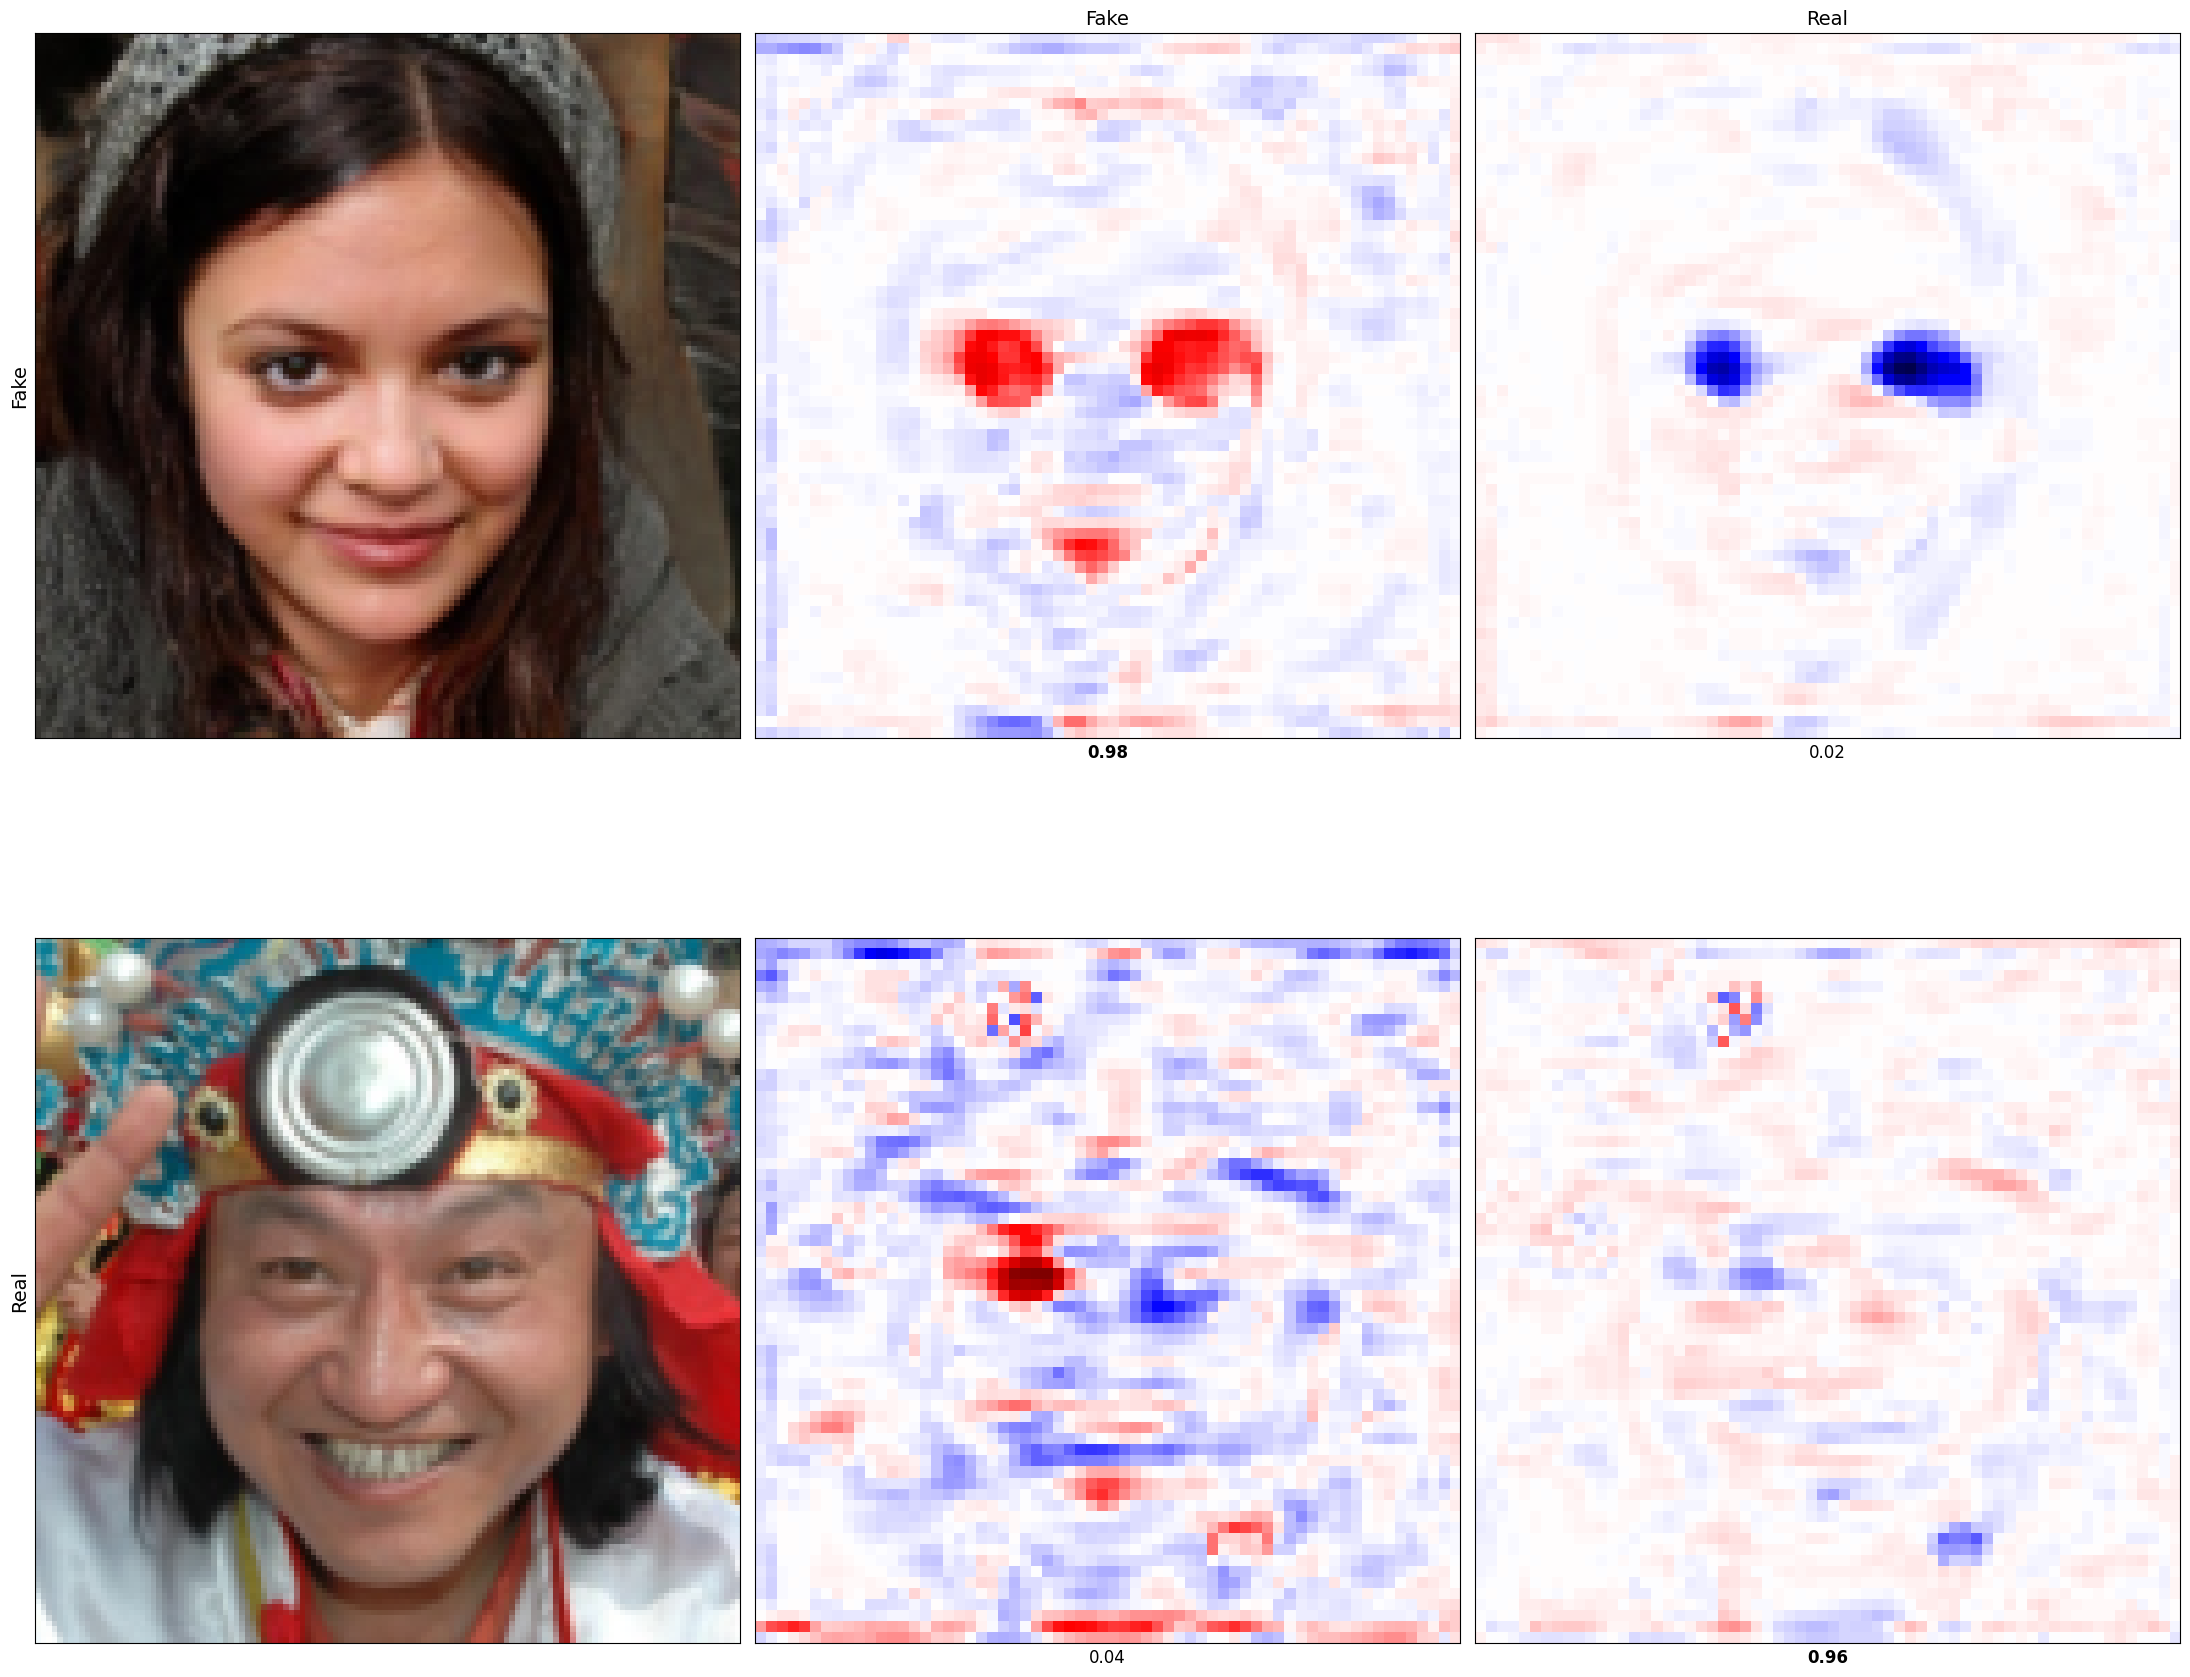

In [13]:
import numpy as np
import matplotlib.pyplot as plt

dset = val_data
targets = np.array(dset.data_frame.iloc[:, 3])  # Assuming labels are in the 4th column of your CSV file
num_classes = len(np.unique(targets))
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Send images to the device
x = x.to(device)

# Get explanations
values = fastshap.shap_values(x)

# Get predictions from the surrogate model
pred = surrogate(
    x,
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

print(pred)

# Set up plotting
fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))
classes = ['Fake', 'Real']  # Adjust these labels to match your class names

# Normalize parameters for displaying images (based on transformation mean/std)
mean = np.array([0.5, 0.5, 0.5])[:, np.newaxis, np.newaxis]
std = np.array([0.5, 0.5, 0.5])[:, np.newaxis, np.newaxis]

for row in range(num_classes):
    # Display original image
    im = x[row].cpu().numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)

    # Display explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)

        # Class labels for the top row
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[col]), fontsize=14)

# Save the figure to the current directory
plt.tight_layout()
# plt.savefig('.explanation.png')  # Save as 'explanations.png' in the current directory
# plt.close()  # Close the plot to free up memory

torch.cuda.empty_cache()

# Exclusion curve

In [14]:
# Load test data
batch_size = 128
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
# Get shapley values and original model predictions
shapley_values = []
preds = []
model.eval()
fastshap.explainer.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        shapley_values.append(fastshap.shap_values(x))
        preds.append(model(x))

shapley_values = np.concatenate(shapley_values, axis=0)
preds = torch.cat(preds, dim=0)

print(shapley_values.shape)
print(preds.shape)

(1000, 2, 64, 64)
torch.Size([1000, 2])


In [16]:
# Select Shapley Values for the Predicted Class
shap_values_select = []
for i, pred in enumerate(preds):
    j = pred.argmax()
    shap_values_select.append(shapley_values[i][j])

shap_values_select = np.array(shap_values_select)
print(shap_values_select.shape)

# Extract Selection Masks: (Remove Top 1%, 5%, 10%, 25%, 50%)
shap_values_flat = shap_values_select.reshape(shap_values_select.shape[0], -1) # Flatten shap_values_select
print(shap_values_flat.shape)

masks_dict = {}
for p in [100, 99, 95, 90, 85, 75, 50, 25, 15, 10, 5, 1]:
    thresholds = np.percentile(shap_values_flat, p, axis=1)

    masks_dict[str(100-p)] = np.array([sv < tr for sv, tr in zip(shap_values_select, thresholds)]).astype(int)

print(len(masks_dict["5"]))
print(masks_dict["5"][0].shape)

(1000, 64, 64)
(1000, 4096)
1000
(64, 64)


In [17]:
masks_in = {}
for p in [100, 99, 95, 90, 85, 75, 50, 25, 15, 10, 5, 1]:
    thresholds = np.percentile(shap_values_flat, p, axis=1)

    masks_in[str(100-p)] = np.array([sv >= tr for sv, tr in zip(shap_values_select, thresholds)]).astype(int)

In [18]:
preds = preds.cpu().numpy()

In [19]:
pred_discrete = preds.argmax(1)
print(pred_discrete[0])

0


In [20]:
batch_size = 1000
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
x = None
for images, labels in test_loader:
    if x is None:
        x = images
    else:
        x = torch.cat((x, images), 0)
print(x.shape)

torch.Size([1000, 3, 128, 128])


In [21]:
for p, masks in masks_dict.items():
        print(masks.shape)
        break

(1000, 64, 64)


In [22]:
with torch.no_grad():
    acc_dict = {}
    for p, masks in masks_dict.items():
        masks = torch.from_numpy(masks.reshape(masks.shape[0], -1)).float().to(device)
        x = x.to(device)
        surr_preds = surrogate(x, masks)
        surr_preds = surr_preds.cpu().numpy()
        surr_preds_discrete = surr_preds.argmax(1)
        count = 0
        for i in range(len(surr_preds_discrete)):
            if surr_preds_discrete[i] == pred_discrete[i]:
                count += 1
        acc_dict[p] = count / len(surr_preds_discrete)


In [23]:
with torch.no_grad():
    acc_in = {}
    for p, masks in masks_in.items():
        masks = torch.from_numpy(masks.reshape(masks.shape[0], -1)).float().to(device)
        x = x.to(device)
        surr_preds = surrogate(x, masks)
        surr_preds = surr_preds.cpu().numpy()
        surr_preds_discrete = surr_preds.argmax(1)
        count = 0
        for i in range(len(surr_preds_discrete)):
            if surr_preds_discrete[i] == pred_discrete[i]:
                count += 1
        acc_in[p] = count / len(surr_preds_discrete)

In [24]:
for p, acc in acc_dict.items():
    print(f"Top {p}%: {acc}")

Top 0%: 0.804
Top 1%: 0.723
Top 5%: 0.499
Top 10%: 0.463
Top 15%: 0.456
Top 25%: 0.435
Top 50%: 0.418
Top 75%: 0.391
Top 85%: 0.365
Top 90%: 0.351
Top 95%: 0.311
Top 99%: 0.33


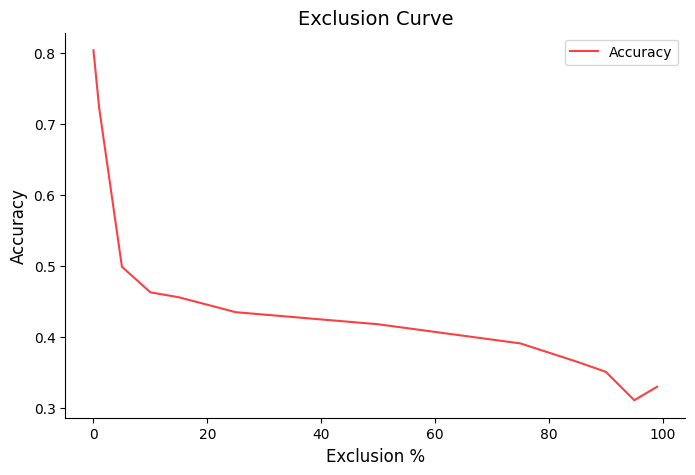

In [25]:
# Extract p and acc values
p_values = [int(p) for p in acc_dict.keys()]  # Convert to integers
acc_values = list(acc_dict.values())

# Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(p_values, acc_values, linestyle='-', color='#f94144', label='Accuracy')

# Add labels and title
plt.xlabel("Exclusion %", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Exclusion Curve", fontsize=14)

# Add a legend
plt.legend()

# Show grid
plt.grid(False)

# Remove upper and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()

In [26]:
# Calculate the area under the curve (AUC) using the trapezoidal rule
auc = np.trapz(acc_values, p_values)

# Print the result
print(f"Area Under the Curve (AUC): {auc}")

Area Under the Curve (AUC): 41.647000000000006


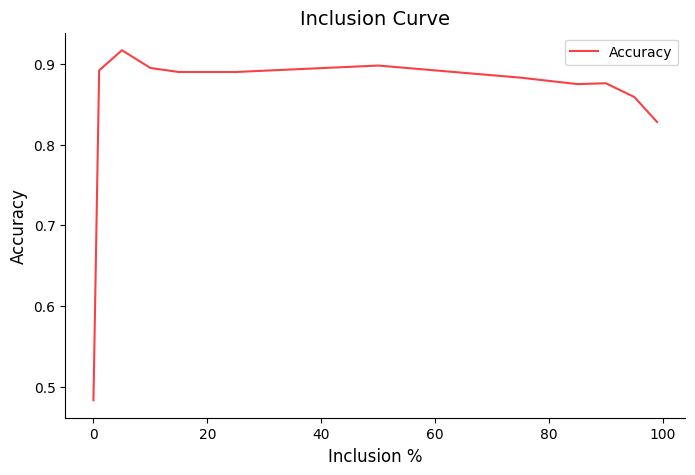

In [27]:
# Extract p and acc values
p_values = [int(p) for p in acc_in.keys()]  # Convert to integers
acc_values = list(acc_in.values())

# Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(p_values, acc_values, linestyle='-', color='#f94144', label='Accuracy')

# Add labels and title
plt.xlabel("Inclusion %", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Inclusion Curve", fontsize=14)

# Add a legend
plt.legend()

# Show grid
plt.grid(False)

# Remove upper and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()

In [28]:
# Calculate the area under the curve (AUC) using the trapezoidal rule
auc = np.trapz(acc_values, p_values)

# Print the result
print(f"Area Under the Curve (AUC): {auc}")

Area Under the Curve (AUC): 87.6895
